In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import sys

In [2]:
def inverse_matrix(matrix):
    det = np.linalg.det(matrix)
    # print(det)
    # if det == 0:
    #     raise Exception("Matrix is not invertible")
    # else:
    n = matrix.shape[0]
    identity = np.identity(n)
    augmented_matrix = np.column_stack((matrix, identity))
    for i in range(n):
        pivot = augmented_matrix[i, i]
        augmented_matrix[i, :] /= pivot
        for j in range(i + 1, n):
            factor = augmented_matrix[j, i]
            augmented_matrix[j, :] -= factor * augmented_matrix[i, :]
    for i in range(n - 1, -1, -1):
        for j in range(i - 1, -1, -1):
            factor = augmented_matrix[j, i]
            augmented_matrix[j, :] -= factor * augmented_matrix[i, :]
    return augmented_matrix[:, n:]


In [3]:
def load_data(filepath):
    """    
    Parameters:
    filepath (cvs): training data.

    Returns:
    x (np.array) : inputs, attributes.
    y (np.array) : outputs.

    """
    X, y = [], []
    with open(filepath, 'r') as file:
        for line in file:
            x, y_ = line.strip().split(',')
            X.append(float(x))
            y.append(float(y_))
    return np.array(X), np.array(y)


def load_sol_data(filepath):
    """    
    Parameters:
    filepath (cvs): solution data.

    Returns:
    m (int) : polynomial degree.
    w (np.array) : weights.

    """
    with open(filepath, 'r') as file:
        m = int(file.readline().strip())
        w = []
        for line in file:
            w_ = float(line.strip())
            w.append(w_)
    return m, np.array(w)



def create_phi(x, degree):
    """
    This function creates a matrix of x values raised to powers.
    :param x: numpy array of input data
    :param degree: degree of the polynomial
    :return: matrix of x values raised to powers
    """
    matrix = np.zeros((len(x), degree + 1))
    for i in range(len(x)):
        for j in range(degree + 1):
            matrix[i][j] = x[i] ** j
    
    return matrix


def regularized_linear_regression(phi, t, lambda_):
    """
    Find the best fitting regularized weights for a linear model using equation 3.28 from PRML.

    Parameters:
    X : Training data input. (trainPath)
    y : Training data output. (modelOutput)
    lambda_ : Regularization parameter.

    Returns:
    w : Best regularized weights.
    """
    i, size = phi.shape
    phi_t = phi.transpose()
    phit_phi = np.matmul(phi_t, phi)
    id = np.identity(size)
    phit_phi_l_i = phit_phi +lambda_ * id
    phit_phi_inv = inverse_matrix(phit_phi_l_i)
    w_reg = np.matmul(phit_phi_inv, phi_t)
    w = np.matmul(w_reg, t)
    return w


def sweep(X, m, lambda_):
    """
    Sweep up to max polynomial (m).

    Parameters:
    X : Training data input. (trainPath)
    m : Given polynomial.
    lambda_ : Regularization parameter.

    Returns:
    weight_list : List of best regularized weights per polynomial.
    """
    weight_list = []
    for i in range(m+1):
        phi_m = create_phi(X, i)
        weight = regularized_linear_regression(phi_m, t, 0)
        weight_list.append(weight)
    return weight_list


def prediction(X, phi, w):
    """
    Compute prediction for polynomial regression.

    Parameters:
    X (np.array) : Training data input.
    phi (matrix) : Matrix of x values raised to powers.
    w (np.array) : Best regularized weights.

    Returns:
    y(X, phi, w) : prediction.
    """

    return np.dot(phi, w)


def small_phi(phi, r):
    return phi[r]


def errorfunction(y, t):
    error = 0.0
    for i in range(len(y)):
        error += (y[i]-t[i])**2

    return 1/2*error

def split_data(x, t, ratio):
    # Shuffle data
    shuffle_index = np.random.permutation(len(x))
    x = x[shuffle_index]
    t = t[shuffle_index]
    
    # Split data into training and test sets
    split_index = int(len(x) * ratio)
    x_train = x[:split_index]
    t_train = t[:split_index]
    x_test = x[split_index:]
    t_test = t[split_index:]
    
    return x_train, t_train, x_test, t_test

def rms(error, N):
    return np.sqrt((2*error)/N)


In [4]:
def solve_curve_fitting(x, t, M, gamma):
    phi = np.array(create_phi(x, M))
    w = regularized_linear_regression(phi, t, gamma)
    y = prediction(x, phi, w)
    error = errorfunction(y, t)
    rms = np.sqrt(2*error/len(x))

    return w, y, error, rms


def split_data(x, t, ratio):
    # Shuffle data
    shuffle_index = np.random.permutation(len(x))
    x = x[shuffle_index]
    t = t[shuffle_index]

    # Split data into training and test sets
    split_index = int(len(x) * ratio)
    x_train = x[:split_index]
    t_train = t[:split_index]
    x_test = x[split_index:]
    t_test = t[split_index:]

    return x_train, t_train, x_test, t_test

def plot_tt(x, t, m, ratio, gamma, plots):
    x_train, t_train, x_test, t_test = split_data(x, t, ratio)
    M = np.arange(0, m)
    train_rms = []
    test_rms = []
    for i in M:
        rms_train = solve_curve_fitting(x_train, t_train, i, gamma)
        train_rms.append(rms_train[3])
        rms_test = solve_curve_fitting(x_test, t_test, i, gamma)
        test_rms.append(rms_test[3])
    if(plots):
        plt.plot(M, train_rms, '-o', label='Train RMS')
        plt.plot(M, test_rms, '-o', label='Test RMS')
        plt.xlabel('M (degree)')
        plt.ylabel('RMS')
        plt.legend()
        plt.show()
    return train_rms, test_rms




In [19]:
input = load_data("sampleData/Y")
X, t = input
M =50
k = 5

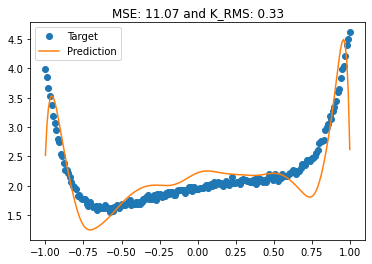

Coefficients: [ 2.22080330e+00  9.96249508e-01 -7.63912160e+00 -1.88048855e+01
  1.90550723e+02  2.08984756e+02 -2.42436277e+03 -1.51952621e+03
  1.72587138e+04  8.62014987e+03 -7.35524269e+04 -3.39178377e+04
  1.89015301e+05  8.42427322e+04 -2.83495365e+05 -1.24967388e+05
  2.44024142e+05  1.01332079e+05 -2.08091300e+05 -3.46882247e+04
  3.30464225e+05 -9.63026345e+03 -2.26504562e+05  3.96073246e+04
 -1.65045725e+05 -5.41645668e+04  9.59365872e+04  2.45849771e+04
  7.99154364e+04  5.47876265e+03  3.11576919e+05 -5.11499003e+04
 -1.42533218e+05  1.05789556e+05 -4.28502304e+05 -7.26533256e+04
 -3.99093309e+04  8.70139562e+04  2.45958035e+05 -2.30017191e+05
  5.34320513e+05  2.91746127e+05 -6.44035779e+05 -2.68121238e+05
  3.74339380e+05  2.43407221e+05 -5.83551757e+05 -1.47286110e+05
  5.27165522e+05  3.61015607e+04 -1.52511210e+05]
Mean Squared Error: 11.067140533089583
Root-Mean-Squared: 0.3326731208422103


In [20]:
fit = solve_curve_fitting(X, t, M, 0.0)
w = fit[0]
y = fit[1]
error = fit[2]
rms = fit[3]

plt.plot(X, t, 'o', label='Target')
plt.plot(X, y, '-', label='Prediction')
plt.legend()
plt.title('MSE: {:.2f}'.format(error) + ' and K_RMS: {:.2f}'.format(rms))
plt.show()

    
print('Coefficients:', w)
# print('Predicted values:', y)
print('Mean Squared Error:', error)
print('Root-Mean-Squared:', rms)

In [12]:
ratio = 7/10
train_rms, test_rms = plot_tt(X, t, M, ratio, 0.0, False)
np.array(train_rms)

array([0.52204168, 0.49635165, 0.30516828, 0.29731255, 0.08550906,
       0.07788064, 0.03014995, 0.02934228, 0.02899012, 0.02894191,
       0.02894114, 0.02891887, 0.02886046, 0.02874298, 0.02855702,
       0.02854451, 0.0278811 , 0.02787673, 0.02786319, 0.02785381,
       0.02786291, 0.02791451, 0.04775854, 0.03543451, 0.13940345,
       0.12141196, 0.12172507, 0.14076212, 0.20207264, 0.11102793,
       0.28071197, 0.22901034, 0.6628493 , 0.32659208, 0.23821238,
       0.35064579, 0.20480162, 0.40417667, 0.49261425, 0.58989376])

In [8]:
a = np.array([1,2,3,4,5,1,6,1]) 
print(np.where(train_rms == train_rms.min()))

AttributeError: 'list' object has no attribute 'min'